In [76]:
import pandas as pd
import numpy as np
import math
from itertools import cycle, product

import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb
import pmdarima as pm

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white, het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [77]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
plt.rcParams["figure.figsize"] = (10,6)

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [78]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [79]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [80]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [81]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.0815,1.0400,0.2273,0.6669,0
3,ffef_tr2_test,0.3036,0.5510,3.1241,0.3807,0


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

In [82]:
t0_df[['FEDFUNDS_diff','ffef_tr','ffef_tr2']].head(20)

,FEDFUNDS_diff,ffef_tr,ffef_tr2
DATE,,,
1962-03-31,0.0567,6.2727,2.8963
1962-06-30,0.1500,6.4035,2.9602
1962-09-30,0.2400,6.3189,3.0465
1962-12-31,0.0767,5.8494,3.2038
1963-03-31,0.0433,5.7059,3.2470
1963-06-30,-0.0033,5.6283,3.2359
1963-09-30,0.3667,6.3850,3.3605
1963-12-31,0.1233,6.7786,3.6363
1964-03-31,0.0100,7.1770,3.8110


In [83]:
t0_df[['FEDFUNDS_diff','ffef_tr_diff','ffef_tr2_diff']].head(20)

,FEDFUNDS_diff,ffef_tr_diff,ffef_tr2_diff
DATE,,,
1962-03-31,0.0567,0.8192,0.6360
1962-06-30,0.1500,0.1308,0.0639
1962-09-30,0.2400,-0.0846,0.0863
1962-12-31,0.0767,-0.4694,0.1573
1963-03-31,0.0433,-0.1436,0.0432
1963-06-30,-0.0033,-0.0776,-0.0111
1963-09-30,0.3667,0.7568,0.1246
1963-12-31,0.1233,0.3936,0.2759
1964-03-31,0.0100,0.3984,0.1747


# Load Data

In [84]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE >= "2000-01-01"').copy()
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


In [85]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

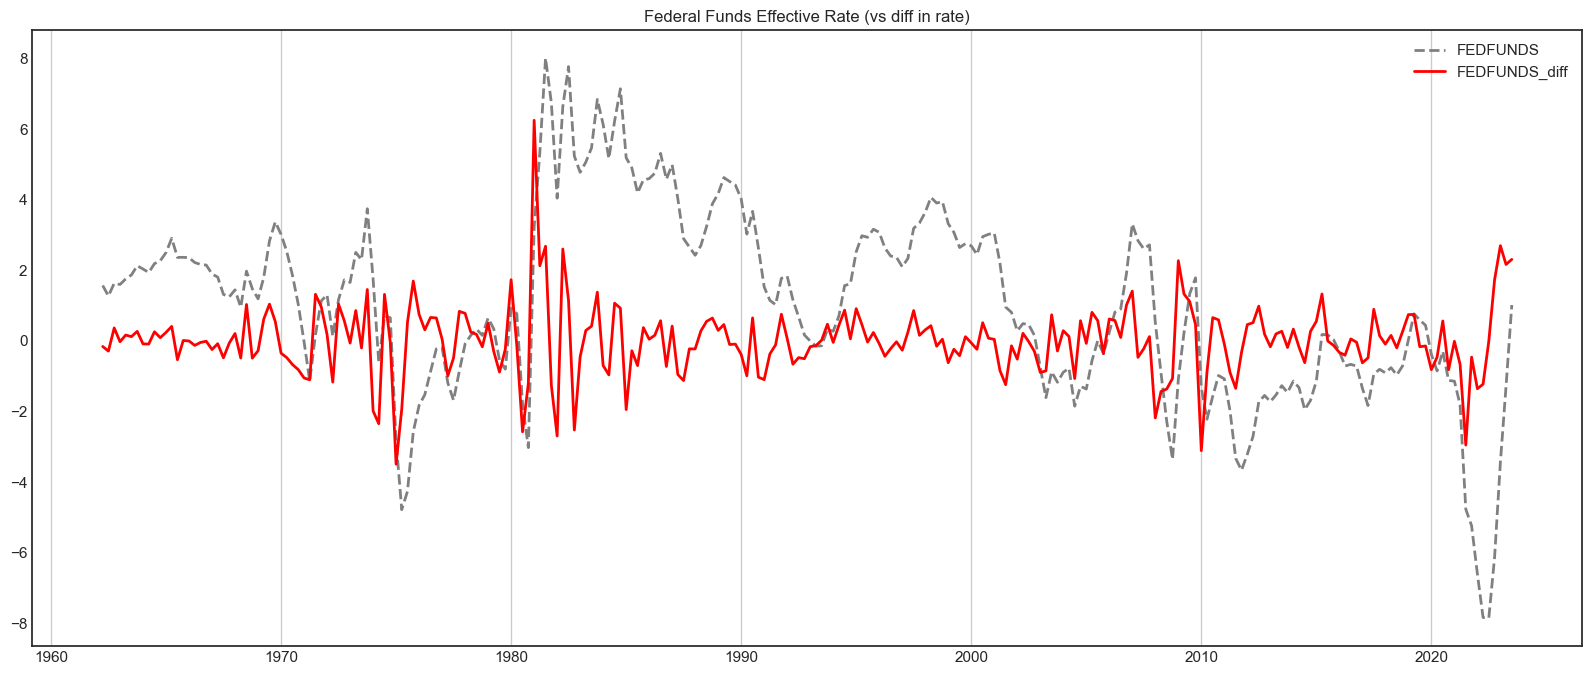

In [86]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Effective Rate (vs diff in rate)');
plt.show()

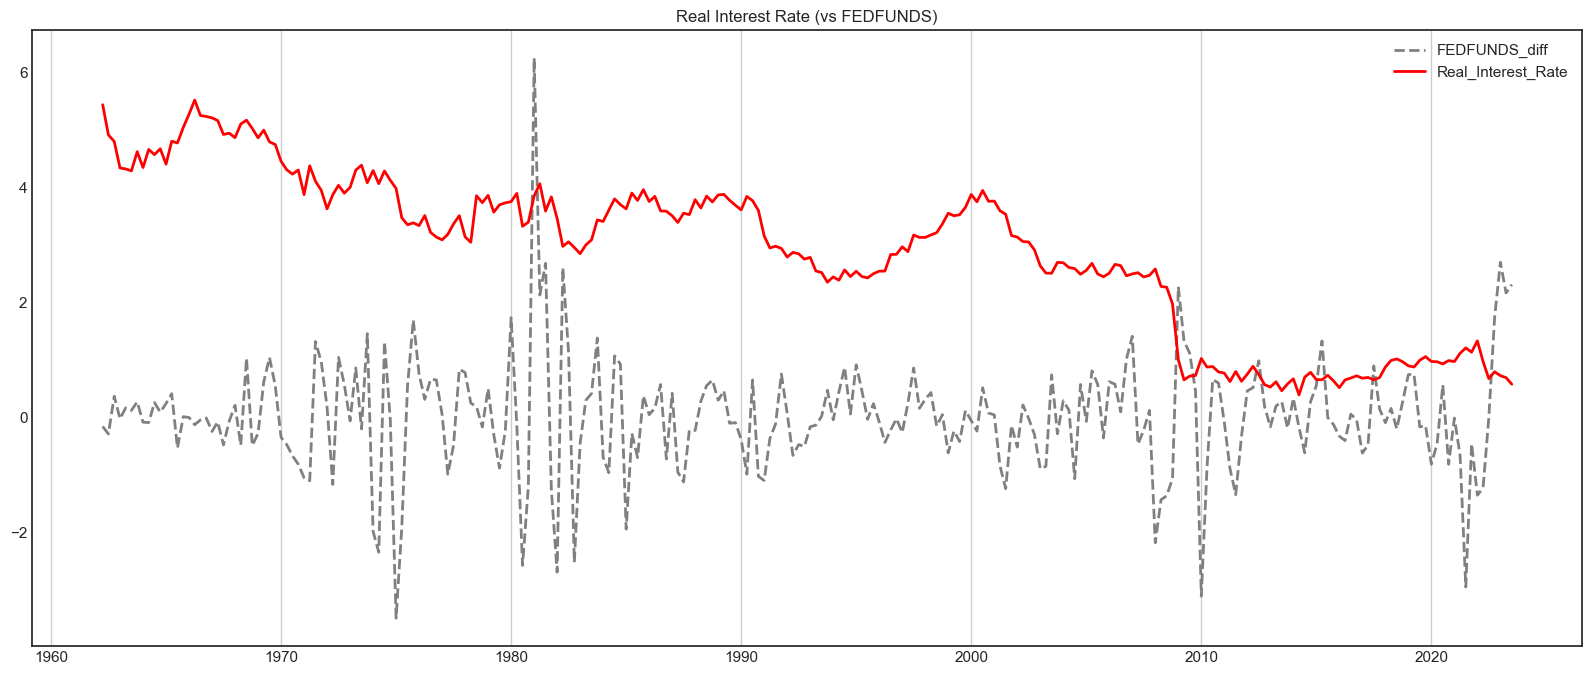

In [87]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'red', linewidth=2)
ax.legend(["FEDFUNDS_diff","Real_Interest_Rate"])
ax.set(title='Real Interest Rate (vs FEDFUNDS)');
plt.show()

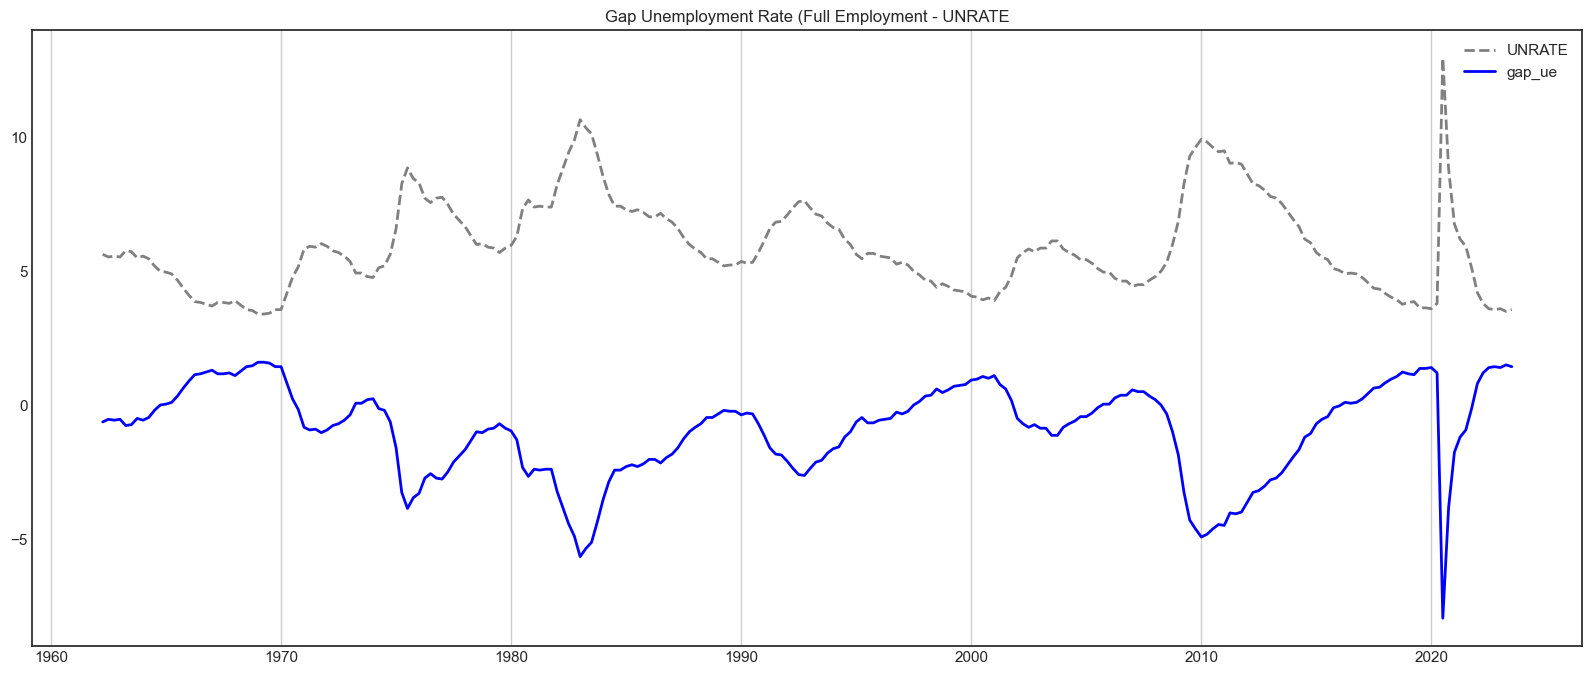

In [88]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

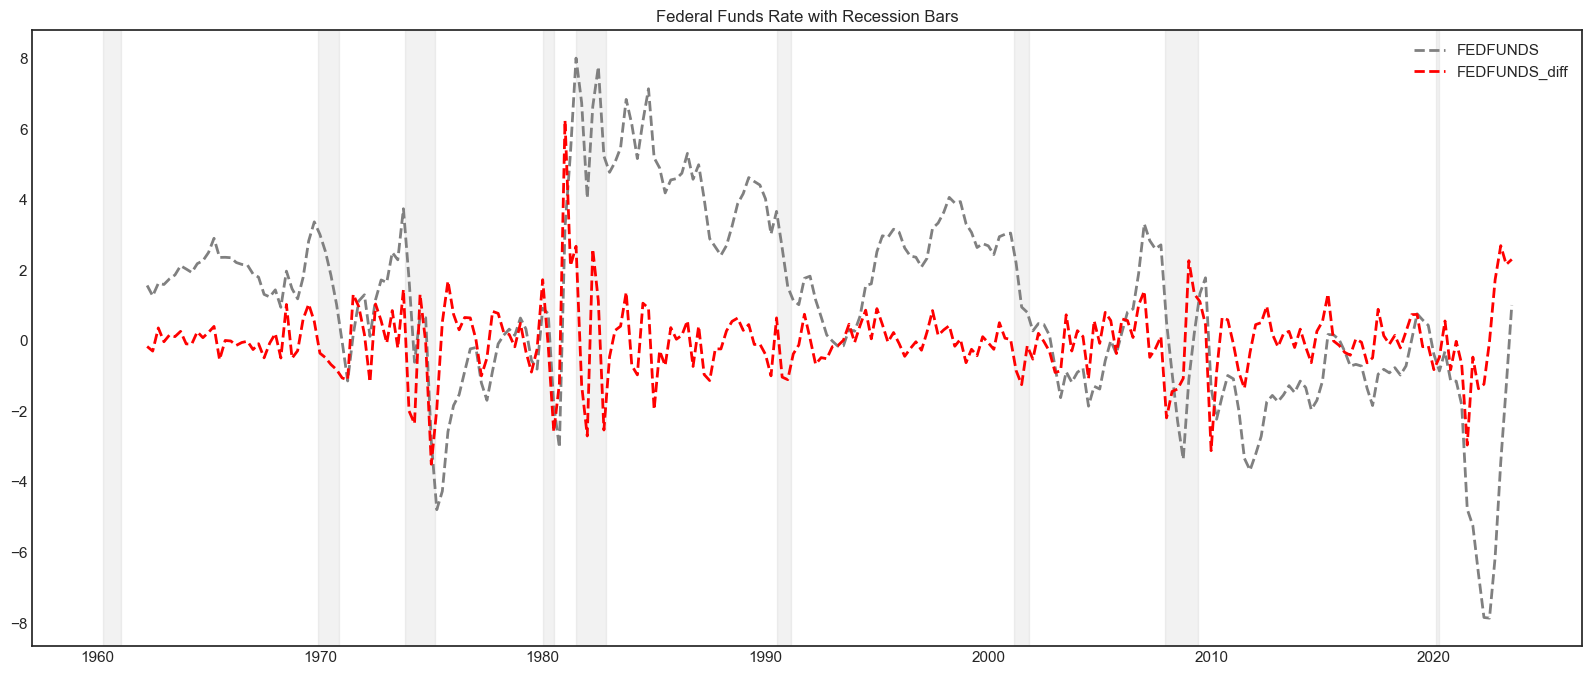

In [89]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_CPIAUCNS_PC1_diff'], linestyle='--', color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

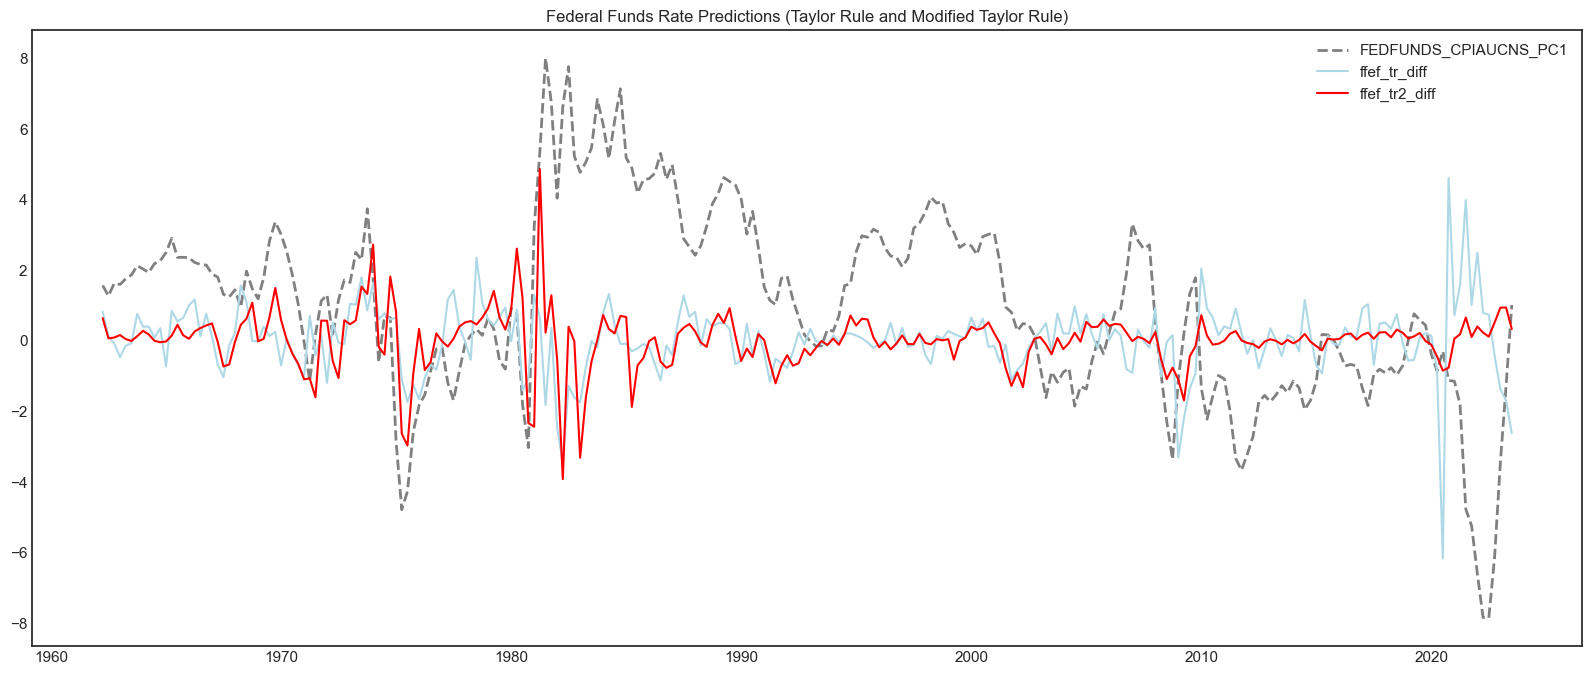

In [90]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr_diff'], color='lightblue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2_diff'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS_CPIAUCNS_PC1", "ffef_tr_diff","ffef_tr2_diff"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

# Case

In [91]:
#test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag', 'CPIAUCSL_PC1']]

In [92]:
#case = 1  # Full Model
#case = 2  # Modified Taylor Rule
#case = 3  # Recession Model
#case = 4  # Simple Model
#case = 5  # Recession Model
#case = 6  # Full Model
#case = 8  # Full Model
case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    #X_train = train_df[['gap_inf', 'gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_gdp','recession_flag', 'CPIAUCSL_PC1']]
    #X_test = test_df[[ 'gap_inf', 'gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS_diff']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    #num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','CPIAUCSL_PC1']
    num_columns_lst = ['gap_inf', 'gap_gdp']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')

    
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    #X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_train = train_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    #X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_test = test_df[['gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf', 'gap_ue','Real_Interest_Rate']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
    
elif case == 3:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1','Real_Interest_Rate']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 4:
    print('-- Simplified Model')
    X_train = train_df[['FEDFUNDS_CPIAUCNS_PC1-1', 'gap_inf', 'gap_ue']]
    #X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['FEDFUNDS_CPIAUCNS_PC1-1', 'gap_inf', 'gap_ue']]
    #X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS_CPIAUCNS_PC1-1','gap_inf', 'gap_ue']
    #num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 5:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS_CPIAUCNS_PC1-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 6:
    print('-- Feature Selection')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 7:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )  
    
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','recession_flag','FEDFUNDS_CPIAUCNS_PC1-1']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','CPIAUCSL_PC1','UNRATE','FEDFUNDS_CPIAUCNS_PC1-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- All Variables


In [93]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (197, 8)


# Diagnostics

- Differencing Order (d): The 'd' parameter in SARIMA specifies the differencing order. If your data is already stationary, you might not need to difference it further (i.e., set 'd' to zero). If the data is non-stationary, you might need to apply differencing to achieve stationarity.
- Auto-Differencing (Seasonal and Regular Differencing): SARIMA models can handle both regular differencing (e.g., 'd' for regular differences) and seasonal differencing (e.g., 'D' for seasonal differences) within the model. This auto-differencing capability allows the model to incorporate differencing as part of its structure.

In [139]:
lag_num = min(10, len(residuals)//5)
alpha = 0.05

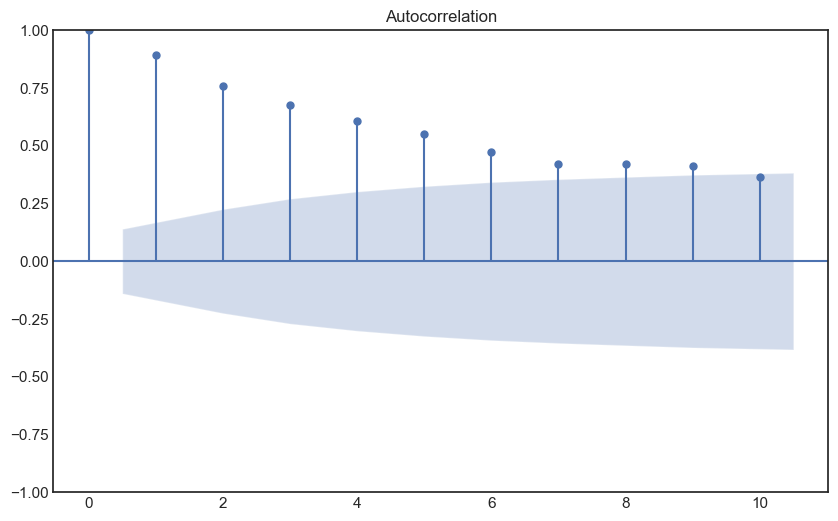

In [140]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS_CPIAUCNS_PC1'], lags=lag_num , alpha=alpha)
acf.show()

Augmented Dickey-Fuller test - 
- If the p-value is less than a chosen significance level (e.g., 0.05), you can reject the null hypothesis of non-stationarity and conclude that the time series is stationary.
- If the p-value is greater than the chosen significance level, there is insufficient evidence to reject the null hypothesis, suggesting that the time series might be non-stationary.

Critical Values
- If the ADF statistic is less (i.e., more negative) than the critical value at a chosen significance level (e.g., 1%), it indicates evidence against the null hypothesis of non-stationarity.
- ADF Stat < critical value - stationary
- ADF Stat > critical value - non stationary

In [95]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS_CPIAUCNS_PC1'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.963826302371414
p-value: 0.30265566893051876
Critical Values:
   1%: -3.4654311561944873
   5%: -2.8769570530458792
   10%: -2.574988319755886


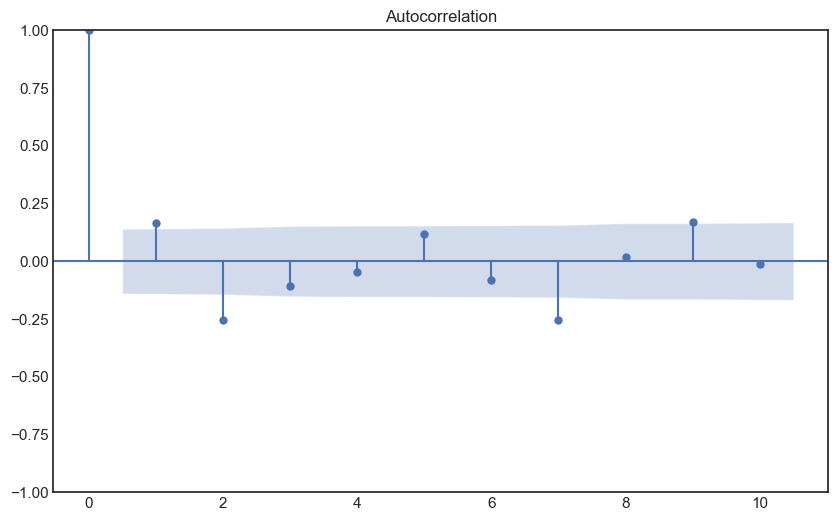

In [141]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS_CPIAUCNS_PC1_diff'], lags=lag_num , alpha=alpha)
acf.show()

In [97]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS_CPIAUCNS_PC1_diff'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -7.336508163199071
p-value: 1.092991601338457e-10
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612



1. Stationarity: SARIMA assumes that the time series data is stationary or can be made stationary after differencing. Stationarity means that the statistical properties of the series (mean, variance, autocorrelation, etc.) remain constant over time.

- First Difference makes that data stationary
- Seasonal Component (S): Captures the seasonality in the time series data.
- Autoregressive Component (AR): Represents the dependence between an observation and a number of lagged observations.
- Differencing (I): Refers to differencing the time series data to make it stationary.
- Moving Average Component (MA): Captures the dependency between an observation and a residual error from a moving average model.

# tsa.SARIMAX

In [142]:
if True:
    # Define ranges for p, d, q, P, D, Q, S
    p = d = q = range(0, 3)

    # Generate all possible combinations of parameters
    param_combinations = list(product(p, d, q))

    # Fit models and select the best one based on evaluation criteria
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for param in param_combinations:
        print('param: ', param)
        try:
            model = sm.tsa.SARIMAX(y_train, enforce_stationarity=True, exog=X_train_trf , order=param[:3], seasonal_order=(0, 0, 0, 4))
            results = model.fit(disp=0)
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = param[:3]
                best_seasonal_order = param[3:]
        except:
            continue

    print(f"Best SARIMAX Order: {best_order}")
    #print(f"Best SARIMAX Seasonal Order: {best_seasonal_order}")

param:  (0, 0, 0)
param:  (0, 0, 1)
param:  (0, 0, 2)
param:  (0, 1, 0)
param:  (0, 1, 1)
param:  (0, 1, 2)
param:  (0, 2, 0)
param:  (0, 2, 1)
param:  (0, 2, 2)
param:  (1, 0, 0)
param:  (1, 0, 1)
param:  (1, 0, 2)
param:  (1, 1, 0)
param:  (1, 1, 1)
param:  (1, 1, 2)
param:  (1, 2, 0)
param:  (1, 2, 1)
param:  (1, 2, 2)
param:  (2, 0, 0)
param:  (2, 0, 1)
param:  (2, 0, 2)
param:  (2, 1, 0)
param:  (2, 1, 1)
param:  (2, 1, 2)
param:  (2, 2, 0)
param:  (2, 2, 1)
param:  (2, 2, 2)
Best SARIMAX Order: (2, 1, 2)


In [99]:
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=best_order, seasonal_order=(1, 1, 1, 4) ,enforce_stationarity=True, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(2,1,3), enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               FEDFUNDS_CPIAUCNS_PC1   No. Observations:                  197
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -233.334
Date:                             Fri, 01 Dec 2023   AIC                            496.668
Time:                                     00:53:15   BIC                            545.531
Sample:                                 03-31-1962   HQIC                           516.458
                                      - 03-31-2011                                         
Covariance Type:                               opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                               -1.0728      0.131     -8.160      0.000      -1.331      -0.815
num__gap_gdp                               -0.4664      0.456     -1.024      0.306      -1.359       0.426
num__gap_ue                                 1.4318      0.252      5.691      0.000       0.939       1.925
num__Real_Interest_Rate                     0.3646      0.632      0.577      0.564      -0.874       1.603
num__CPIAUCSL_PC1                          -1.0728      0.131     -8.160      0.000      -1.331      -0.815
num__UNRATE                                -1.4337      0.252     -5.698      0.000      -1.927      -0.941
num__FEDFUNDS_CPIAUCNS_PC1-1                0.6270      0.229      2.741      0.006       0.179       1.075
cat__onehotencoder__recession_flag_True    -0.3467      0.237     -1.464      0.143      -0.811       0.117
ar.L1                                      -1.2169      0.241     -5.056      0.000      -1.689      -0.745
ar.L2                                      -0.6126      0.180     -3.409      0.001      -0.965      -0.260
ma.L1                                       1.1763      0.323      3.646      0.000       0.544       1.809
ma.L2                                       0.3836      0.274      1.399      0.162      -0.154       0.921
ar.S.L4                                     0.3657      0.098      3.746      0.000       0.174       0.557
ma.S.L4                                    -0.9955      0.709     -1.405      0.160      -2.384       0.393
sigma2                                      0.6198      0.429      1.446      0.148      -0.221       1.460
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               428.03
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.77
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+17. Standard errors may be unstable.
"""

<br>

Covariance matrix calculation using the outer product of gradients (complex-step):
- issues with the stability of standard errors.
- Generally, this warning message itself is not an issue unless it's accompanied by other warnings related to convergence or instability.

<br>

Covariance matrix is singular or near-singular, with a high condition number:

- The condition number measures the stability of the covariance matrix. A high condition number (in your case, 3.37e+16) indicates that the matrix is nearly singular or ill-conditioned.
- An ill-conditioned covariance matrix could lead to unstable standard errors for parameter estimates. It implies that the estimation process might be numerically challenging, making the model results less reliable.

<br>

**kurtosi**

Here's a basic interpretation of kurtosis in the context of SARIMA modeling:

<br>

+ Positive Kurtosis:
    - A positive kurtosis indicates that the distribution of residuals has heavier tails and is more peaked (leptokurtic) than a normal distribution.
    - In the context of SARIMA, positive kurtosis might suggest that the residuals have more extreme values (outliers) or a higher likelihood of extreme events than a normal distribution.

<br>

+ Negative Kurtosis:
    - Negative kurtosis indicates that the distribution of residuals has lighter tails and is less peaked (platykurtic) than a normal distribution.
    - In the context of SARIMA, negative kurtosis might suggest that the residuals have fewer extreme values or flatter tails compared to a normal distribution.

<br>

+ Interpretation Caveat:
    - While kurtosis provides information about the shape of the distribution, it's important not to solely rely on kurtosis to draw conclusions about the residuals' behavior. It's essential to consider other measures and conduct thorough diagnostics, such as visual inspections, normality tests, and additional statistical assessments.


In [100]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)
train_pred_SARIM = train_result.summary_frame()

<br>

### Model Diagnostics

The plot_diagnostics() function generates a set of four plots:

- Standardized Residuals Plot: Displays the standardized residuals over time. Look for patterns or large deviations from zero, indicating potential issues with the model's fit or variance. **Check for constant variance, patterns, or outliers.**
- Histogram Plus Estimated Density: Shows the histogram of residuals along with an estimated density plot. It helps in assessing the normality assumption of the residuals. 
- Normal Q-Q Plot: A quantile-quantile (Q-Q) plot compares the distribution of residuals against a theoretical normal distribution. Deviations from the diagonal line suggest non-normality. **Assess the normality assumption of residuals. Deviations from a straight line indicate non-normality.**
- Correlogram: Plots the autocorrelation function (ACF) of the residuals to detect any remaining autocorrelation. **Look for any significant autocorrelation in residuals.**

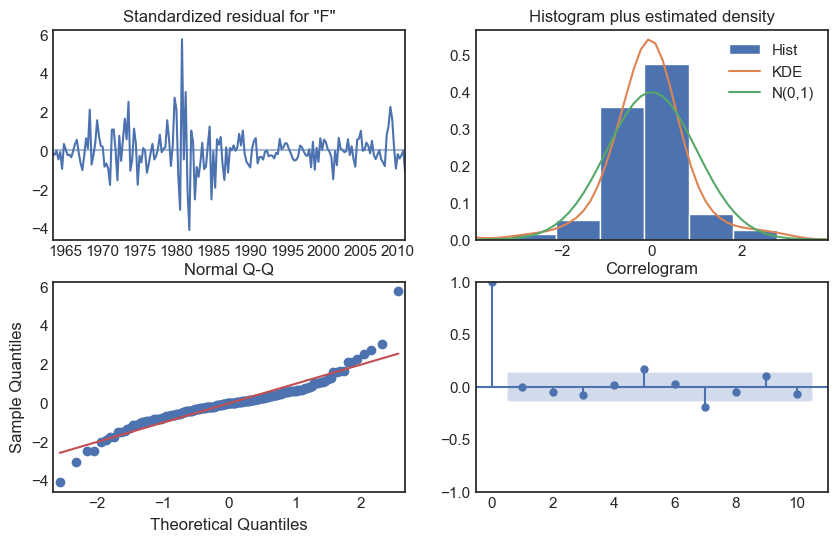

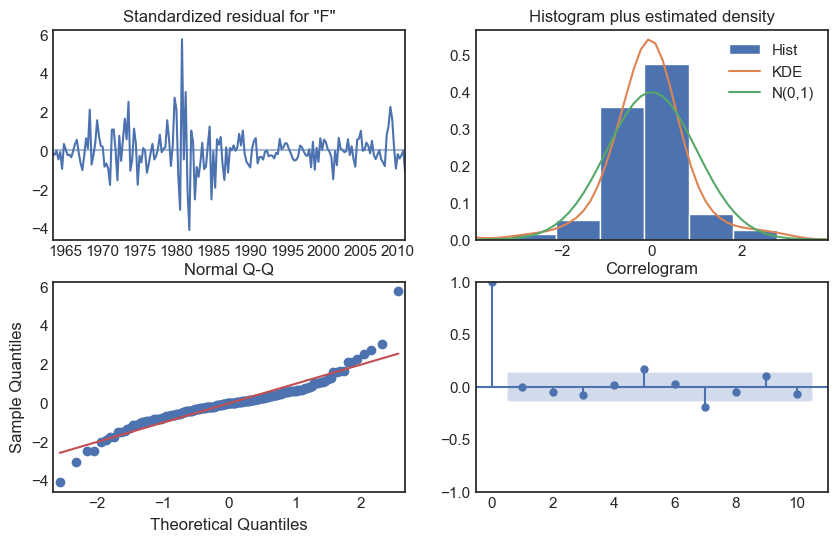

In [101]:
result_model.plot_diagnostics()

### Observations

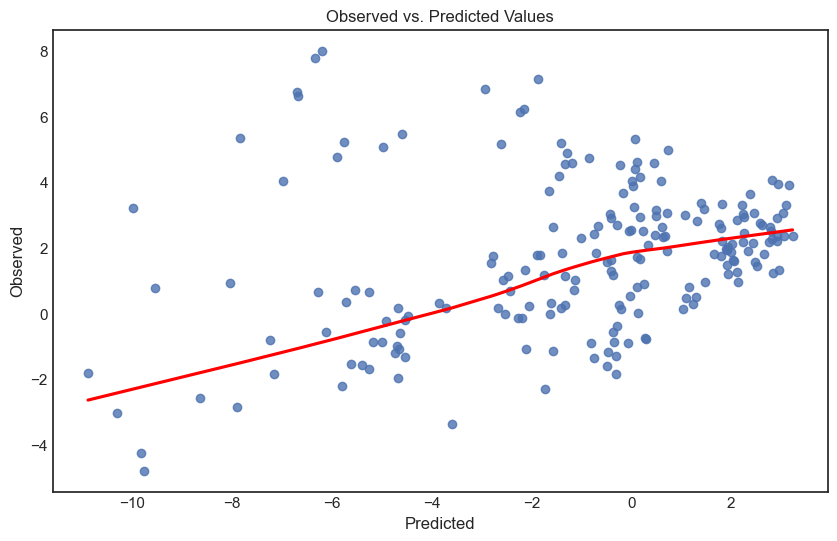

In [102]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_SARIM['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()


### Residuals Analysis

**No Seasonal Patterns** in Residuals: The residuals should not exhibit any seasonality or pattern after fitting the SARIMA model.
Visual Inspection: Observe the plot for any visible patterns in the variance of residuals. Departures from constant variance could indicate heteroskedasticity.
- residual plot and the acf plot

**Independence of Errors:** SARIMA assumes that the residuals (errors) of the model are independent and identically distributed (i.i.d.). Residuals should not exhibit patterns or correlation after fitting the model. 
- Ljung-Box

Normality of Residuals: While not as critical as in some other models, it's beneficial if residuals are normally distributed. Departures from normality might suggest that the model doesn't capture all the information in the data.
- skip this test

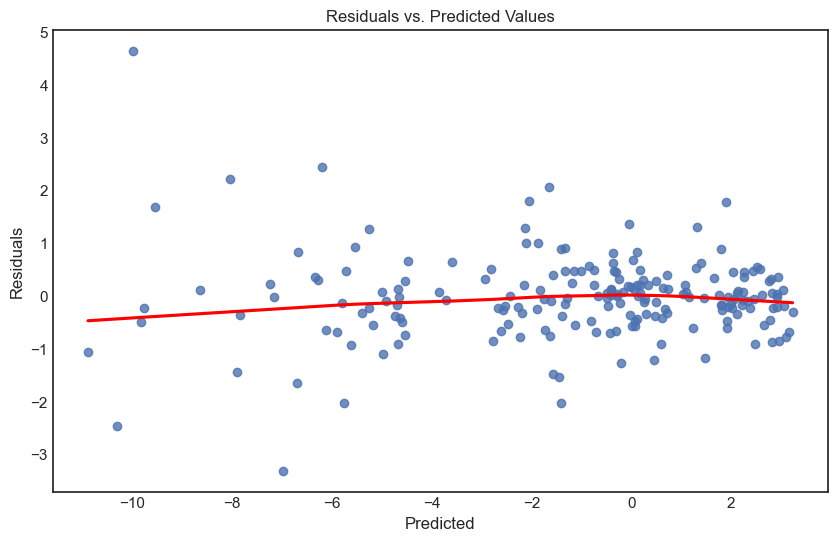

In [103]:
# independence of residuals
residuals = result_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_SARIM['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

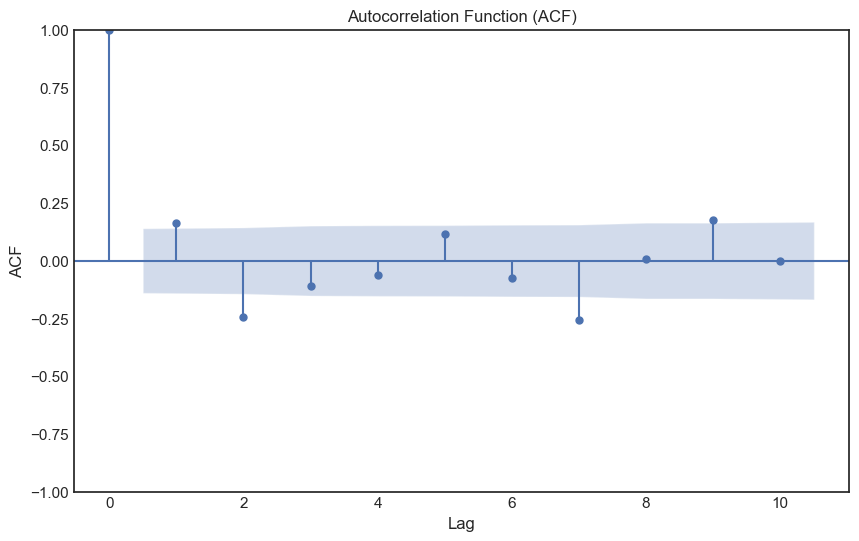

In [154]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

heteroskedastic - the variance of the residuals is not constant

In [144]:
#lags = min(10, len(residuals)//5)

res = result_model.test_serial_correlation(method='ljungbox', lags=lag_num)
res_df = pd.DataFrame({ 'lag' : range(1, lag_num+1),
                        'test_statistic' : res[:,0][0],
                        'p_value' : res[:,1][0]})
res_df

,lag,test_statistic,p_value
0,1,0.0065,0.9360
1,2,0.4583,0.7952
2,3,1.6890,0.6394
3,4,1.7131,0.7883
4,5,7.3498,0.1959
5,6,7.4624,0.2802
6,7,15.3549,0.0317
7,8,15.9264,0.0434
8,9,18.1308,0.0337
9,10,19.2428,0.0373


**Heteroskedasticity (changing variance)**

- If we used a heteroskedastic robust estimate of the covariance matrix, maybe we would correct for that weird result.
- Constant Variance: The variance of the residuals should remain constant across time. Heteroskedasticity (changing variance) in residuals can affect the reliability of model results.

In [105]:
test_stat, p_val = result_model.test_heteroskedasticity(method = 'breakvar')[0]
print('--- heteroskedasticity -- ')
print('test_stat: ',test_stat, '  ' , 'p_val: ', p_val)

--- heteroskedasticity -- 
test_stat:  0.5601777073996699    p_val:  0.021837960939093428


ARCH Test: A lower p-value (< 0.05) suggests evidence against constant variance (presence of heteroskedasticity). 

A higher p-value indicates that there is no strong evidence against constant variance.

In [106]:
res = het_arch(residuals)
print('--- heteroskedasticity -- ')
print('ARCH Test Results: ',res[0], '  ' , 'p_val: ', res[1])

--- heteroskedasticity -- 
ARCH Test Results:  58.17952228585535    p_val:  7.997254886466613e-09


In [107]:
test_stat, p_val = result_model.test_heteroskedasticity(method = 'breakvar')[0]
print('--- heteroskedasticity -- ')
print('test_stat: ',test_stat, '  ' , 'p_val: ', p_val)

--- heteroskedasticity -- 
test_stat:  0.5601777073996699    p_val:  0.021837960939093428


In [108]:
print('aic', result_model.aic)

aic 496.6680918727875


## Test

In [109]:
X_test_trf = t_fit.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = test_df.index
X_test_trf.set_index('DATE', inplace=True)


y_test = test_df['FEDFUNDS']

In [110]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [111]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(49, 4)

In [112]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.columns = ['lower', 'upper']
predict_ci.head()

,lower,upper
2011-06-30,-3.3784,-2.3080
2011-09-30,-3.8669,-2.3837
2011-12-31,-3.6874,-1.9855
2012-03-31,-3.0403,-1.0164
2012-06-30,-2.2314,0.1786


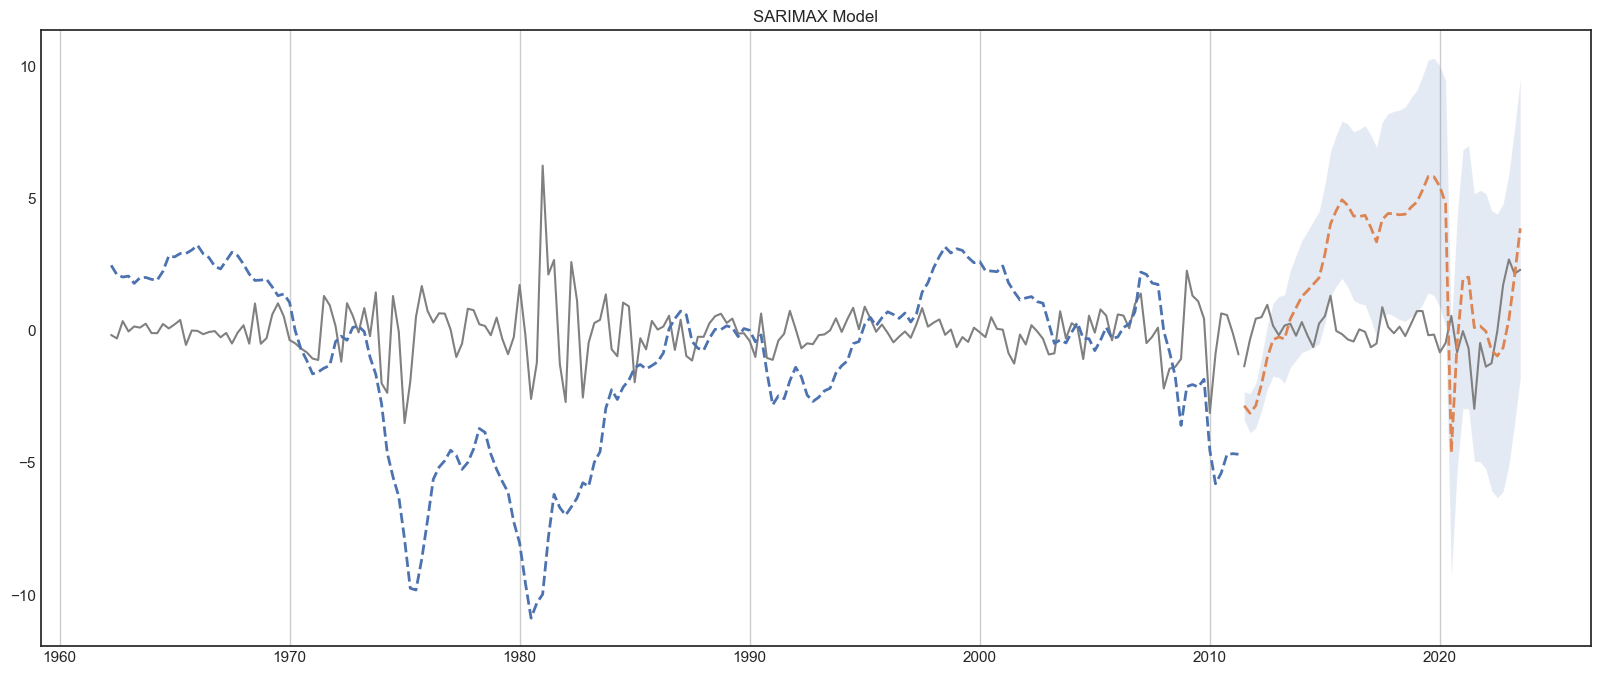

In [113]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower'], predict_ci['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [114]:
model_stats_df = model_results('SARIMAX_train',y_train, train_pred_SARIM['mean'], result_model.aic, model_stats_df )
model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], 0, model_stats_df )

# auto arima

In [115]:
# Initiate and Fit Model
arima_model = pm.auto_arima(y = y_train, 
                            X = X_train_trf,
                            start_d = 1,
                            #d = 1,
                            test='adf', 
                            seasonal=False, 
                            error_action='ignore',  
                            suppress_warnings=False,
                            stepwise=True, trace=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=499.014, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=802.776, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=504.520, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=706.860, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=497.348, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=679.098, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=505.203, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=498.379, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=617.698, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=501.570, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=501.300, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=498.149, Time=0.19 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.631 seconds


In [116]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  197
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -236.674
Date:                Fri, 01 Dec 2023   AIC                            497.348
Time:                        00:53:18   BIC                            536.747
Sample:                    03-31-1962   HQIC                           513.297
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                               -0.9386      0.158     -5.941      0.000      -1.248      -0.629
num__gap_gdp                               -0.3792      0.569     -0.667      0.505      -1.494       0.736
num__gap_ue                                 1.1743      0.245      4.794      0.000       0.694       1.655
num__Real_Interest_Rate                     0.2919      0.765      0.381      0.703      -1.208       1.792
num__CPIAUCSL_PC1                          -0.9386      0.158     -5.941      0.000      -1.248      -0.629
num__UNRATE                                -1.1746      0.245     -4.794      0.000      -1.655      -0.694
num__FEDFUNDS_CPIAUCNS_PC1-1                0.2411      0.340      0.708      0.479      -0.426       0.908
cat__onehotencoder__recession_flag_True    -0.0998      0.254     -0.393      0.695      -0.598       0.398
ar.L1                                       0.9815      0.013     76.831      0.000       0.956       1.007
ma.L1                                       0.1124      0.156      0.720      0.472      -0.194       0.418
ma.L2                                      -0.2355      0.056     -4.172      0.000      -0.346      -0.125
sigma2                                      0.6368      0.037     17.092      0.000       0.564       0.710
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1968.60
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             2.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.61e+17. Standard errors may be unstable.
"""

<br>

### Model Diagnostics
Here's a brief interpretation of the AIC in the context of auto_arima:

- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.
- Comparing AIC values: When comparing models fitted by auto_arima, select the model with the lowest AIC value as it suggests the best balance between explaining the variance in the data and model complexity.
- AIC as a relative measure: The AIC doesn't provide an absolute measure of goodness of fit, but rather a relative measure among candidate models. You can compare AIC values across different models to identify the one that best fits the data while keeping the model as simple as possible.


According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is greater than 0.05, so we cannot reject the null hypothesis of independence, but we cannot say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is smaller than 0.05.

This time, the p-value of the Heteroskedasticity test is greater than 0.05, indicating that the model explains better the variance in the data. This model outperforms the previous one in terms of dependability. This demonstrates that ARIMA is superior for short-term forecasting.

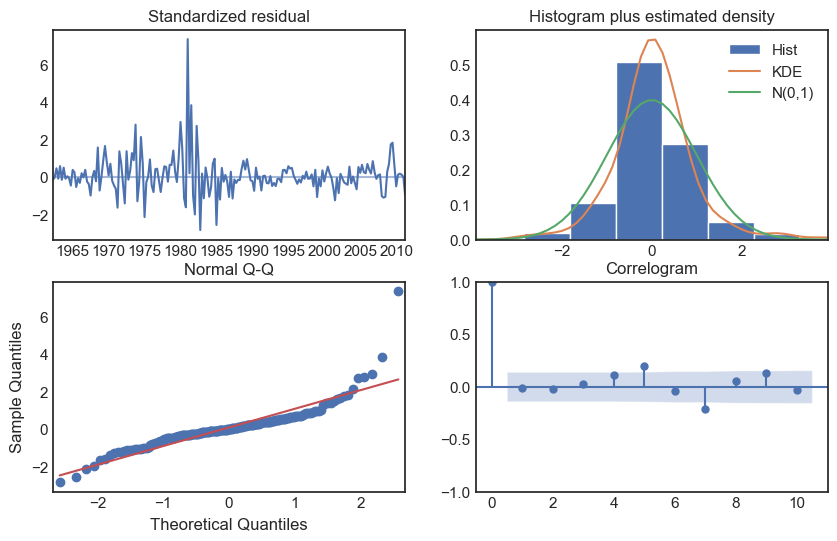

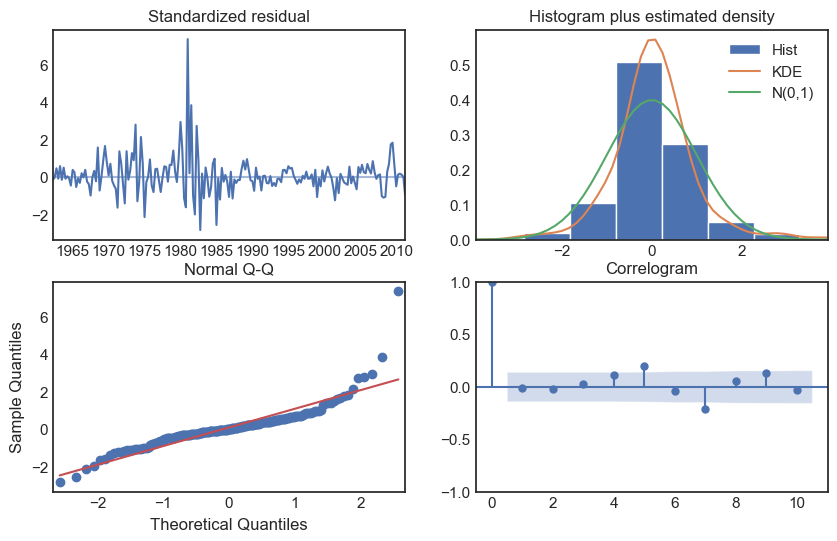

In [117]:
arima_model.plot_diagnostics()

We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution (but this is not a strict requirement to validate the model).

In [118]:
predict, confint = arima_model.predict_in_sample(X=X_train_trf, return_conf_int=True)
train_pred_pmdarima = pd.DataFrame(predict)
train_pred_pmdarima.columns = ['mean']
train_pred_pmdarima['lower'] = confint[:,0]
train_pred_pmdarima['upper'] = confint[:,1]
train_pred_pmdarima.shape

(197, 3)

### Observations Analysis

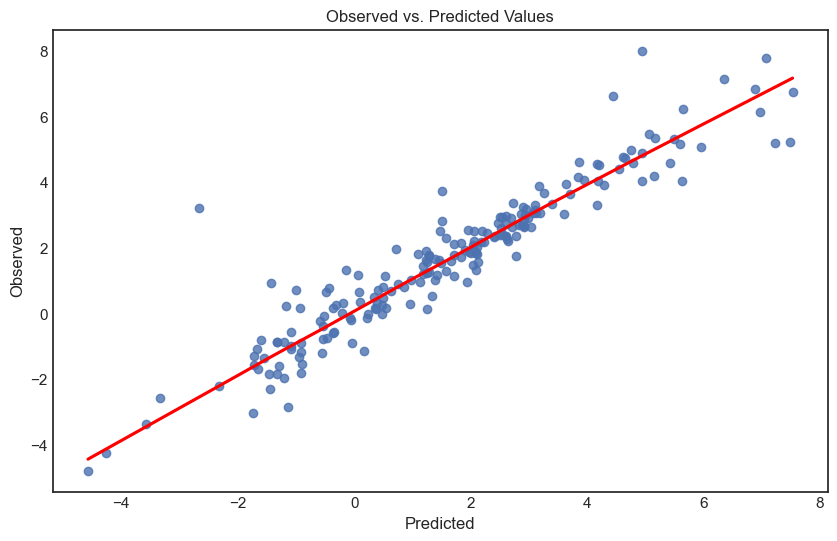

In [119]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_pmdarima['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

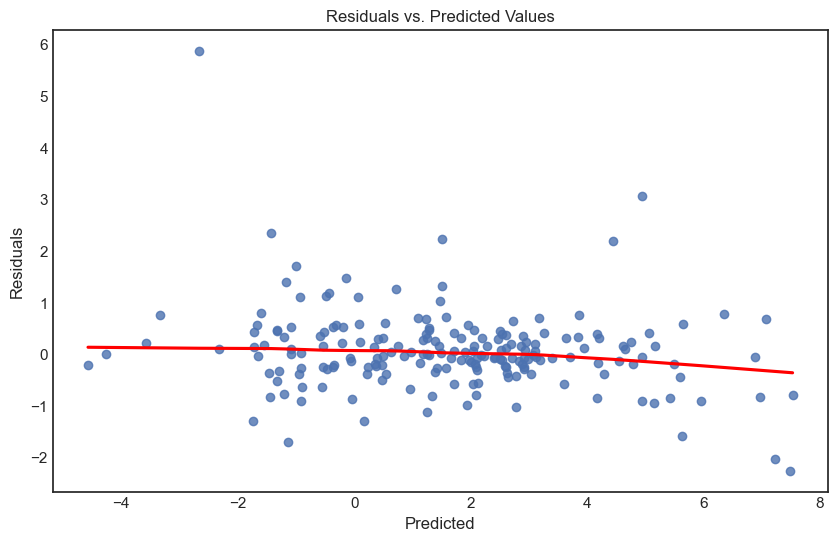

In [120]:
# independence of residuals
residuals = arima_model.resid()

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

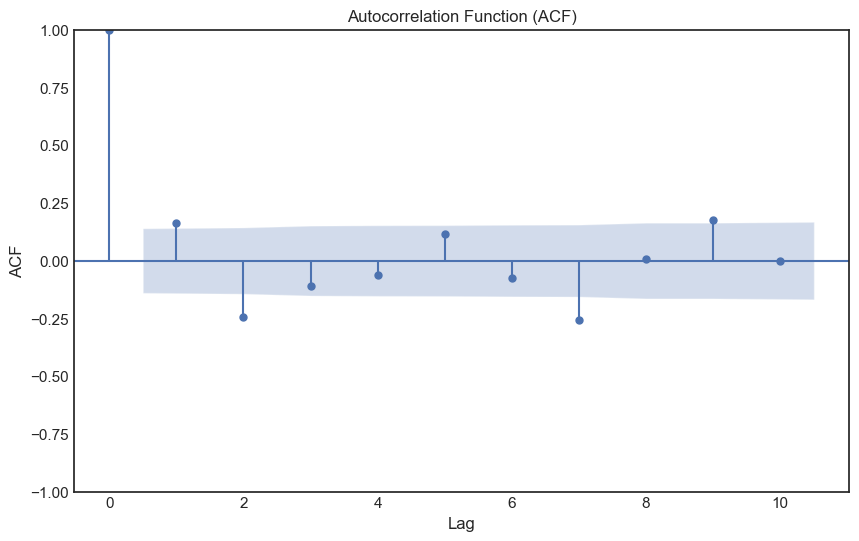

In [153]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

In [121]:
lags = min(10, len(residuals)//5)  # Adjust the number of lags as needed
res_df = acorr_ljungbox(residuals, lags=lags)

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
res_df

Ljung-Box Test Results:


,lb_stat,lb_pvalue
1,0.0356,0.8503
2,0.1399,0.9324
3,0.2245,0.9735
4,2.6161,0.6240
5,10.7420,0.0567
6,11.1064,0.0851
7,20.7652,0.0041
8,21.3369,0.0063
9,25.0010,0.0030
10,25.2135,0.0050


## Test

In [122]:
forecast, confint = arima_model.predict(len(y_test) , X=X_test_trf, return_conf_int=True)
test_pred_pmdarima = pd.DataFrame(forecast)
test_pred_pmdarima.columns = ['mean']
test_pred_pmdarima['lower'] = confint[:,0]
test_pred_pmdarima['upper'] = confint[:,1]
test_pred_pmdarima.shape

(49, 3)

In [123]:
model_stats_df = model_results('pmdarima_train',y_train, train_pred_pmdarima['mean'], arima_model.aic() , model_stats_df )
model_stats_df = model_results('pmdarima_test', y_test, test_pred_pmdarima['mean'], 0 , model_stats_df )

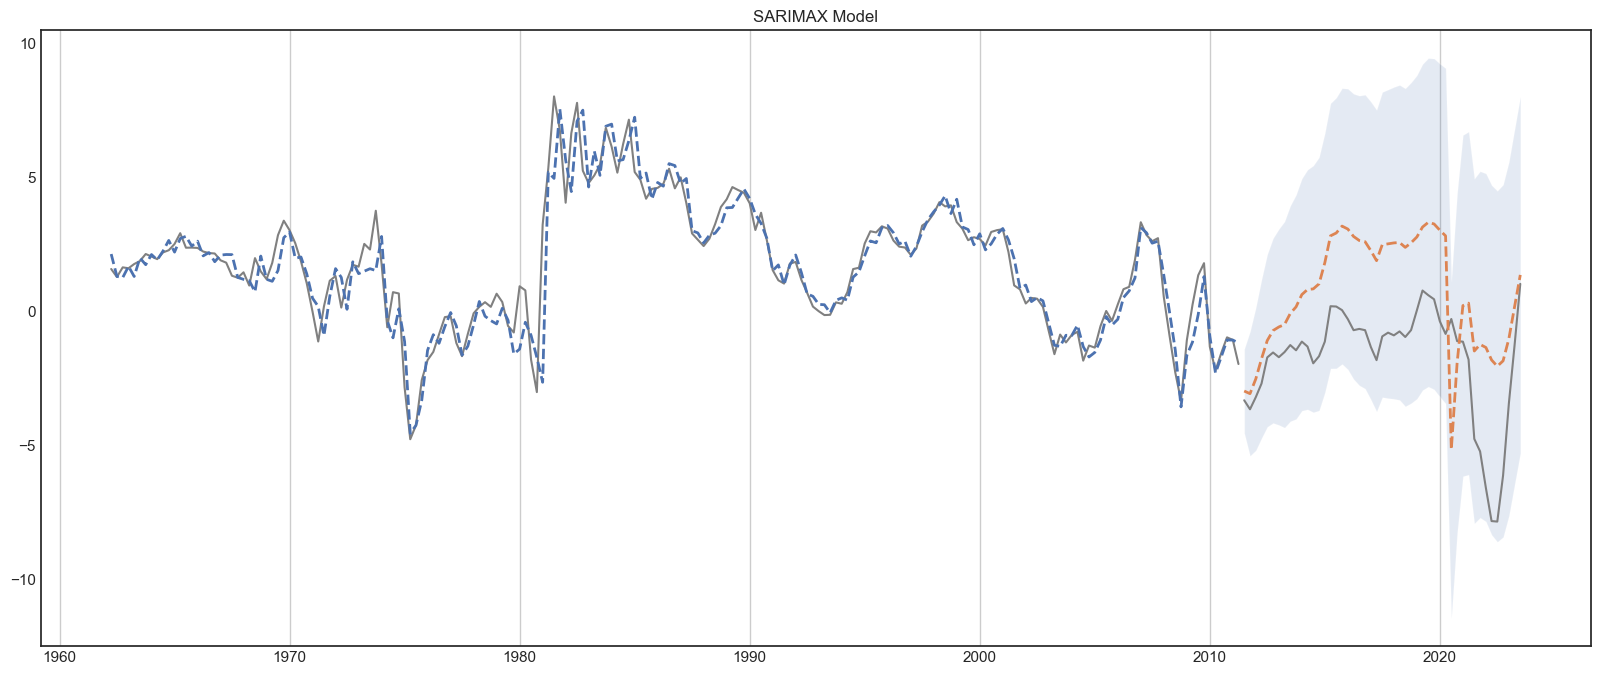

In [124]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray')
ax.plot(train_pred_pmdarima.index, train_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_pmdarima.index, test_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

# ETSModel

In [125]:
ets_model = ETSModel(train_df['FEDFUNDS_CPIAUCNS_PC1_diff'], error='add', trend='add', seasonal='add', seasonal_periods=4)

fit_ets_model = ets_model.fit(disp=False)

In [126]:
fit_ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     FEDFUNDS_CPIAUCNS_PC1_diff   No. Observations:                  197
Model:                               ETS(AAA)   Log Likelihood                -281.700
Date:                        Fri, 01 Dec 2023   AIC                            583.399
Time:                                00:53:20   BIC                            616.232
Sample:                            03-31-1962   HQIC                           596.690
                                 - 03-31-2011   Scale                            1.022
Covariance Type:                       approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0001        nan        nan        nan         nan         nan
smoothing_trend         1e-08      0.002   6.24e-06      1.000      -0.003       0.003
smoothing_seasonal  9.999e-05        nan        nan        nan         nan         nan
initial_level         -0.0911      0.162     -0.562      0.574      -0.409       0.227
initial_trend         -0.0005      0.001     -0.431      0.666      -0.003       0.002
initial_seasonal.0     0.0190      0.132      0.144      0.885      -0.240       0.278
initial_seasonal.1     0.2164      0.132      1.642      0.101      -0.042       0.475
initial_seasonal.2     0.2723      0.132      2.069      0.039       0.014       0.530
initial_seasonal.3          0      0.130          0      1.000      -0.255       0.255
===================================================================================
Ljung-Box (Q):                       38.42   Jarque-Bera (JB):               579.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.84
Prob(H) (two-sided):                  0.85   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+16. Standard errors may be unstable.
"""

In [127]:
train_pred_ets = fit_ets_model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred_ets = pd.DataFrame({'mean' : train_pred_ets})
train_pred_ets.index.name = 'DATE'
train_pred_ets.shape

(197, 1)

### Observations Analysis

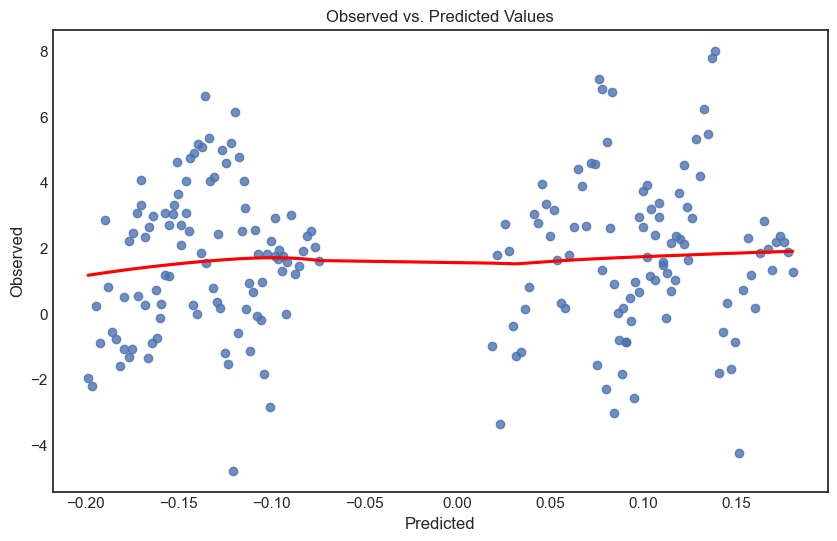

In [128]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_ets['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

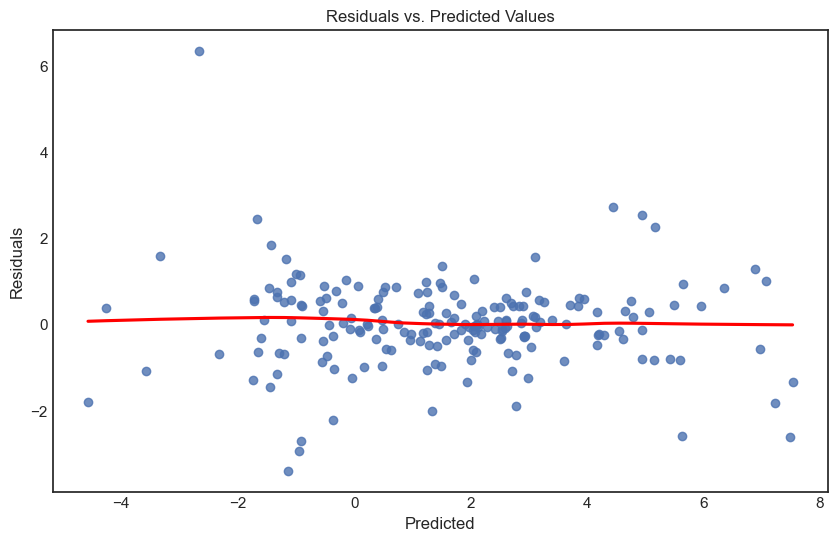

In [129]:
# independence of residuals
residuals = fit_ets_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

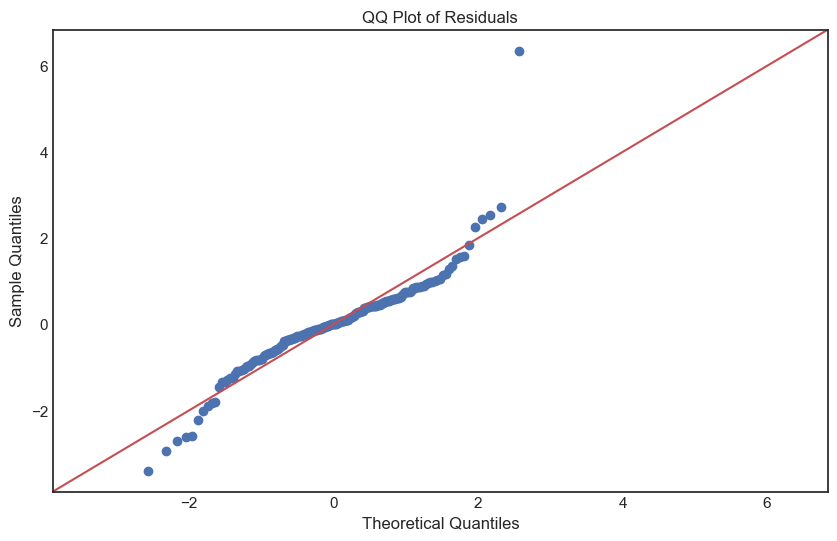

In [130]:
# Create a QQ plot for the residuals
sm.qqplot(residuals, line='45')  # 'line='45'' adds a 45-degree line for reference
plt.title('QQ Plot of Residuals')
plt.show()

<Figure size 300x200 with 0 Axes>

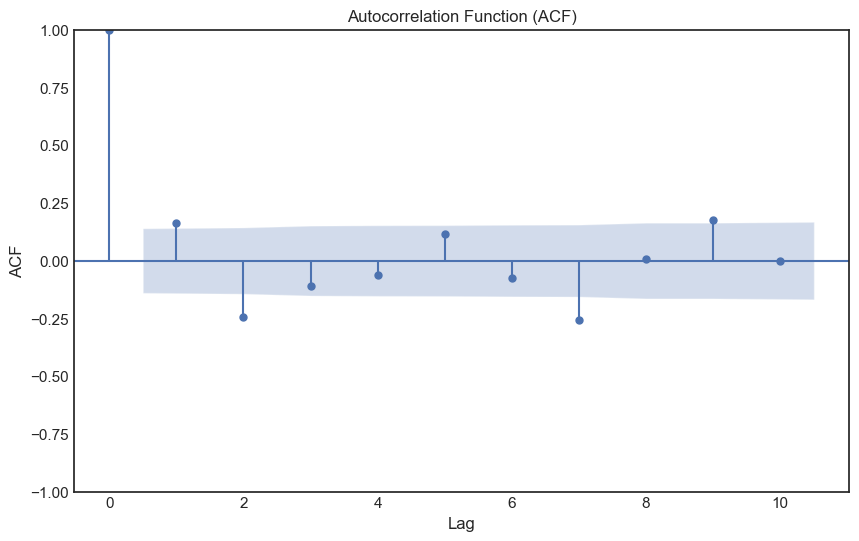

In [152]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

In [132]:
test_pred_ets = fit_ets_model.forecast(steps=y_test.shape[0]) 
test_pred_ets = pd.DataFrame({'mean' : test_pred_ets})
test_pred_ets.index.name = 'DATE'
test_pred_ets.shape

(49, 1)

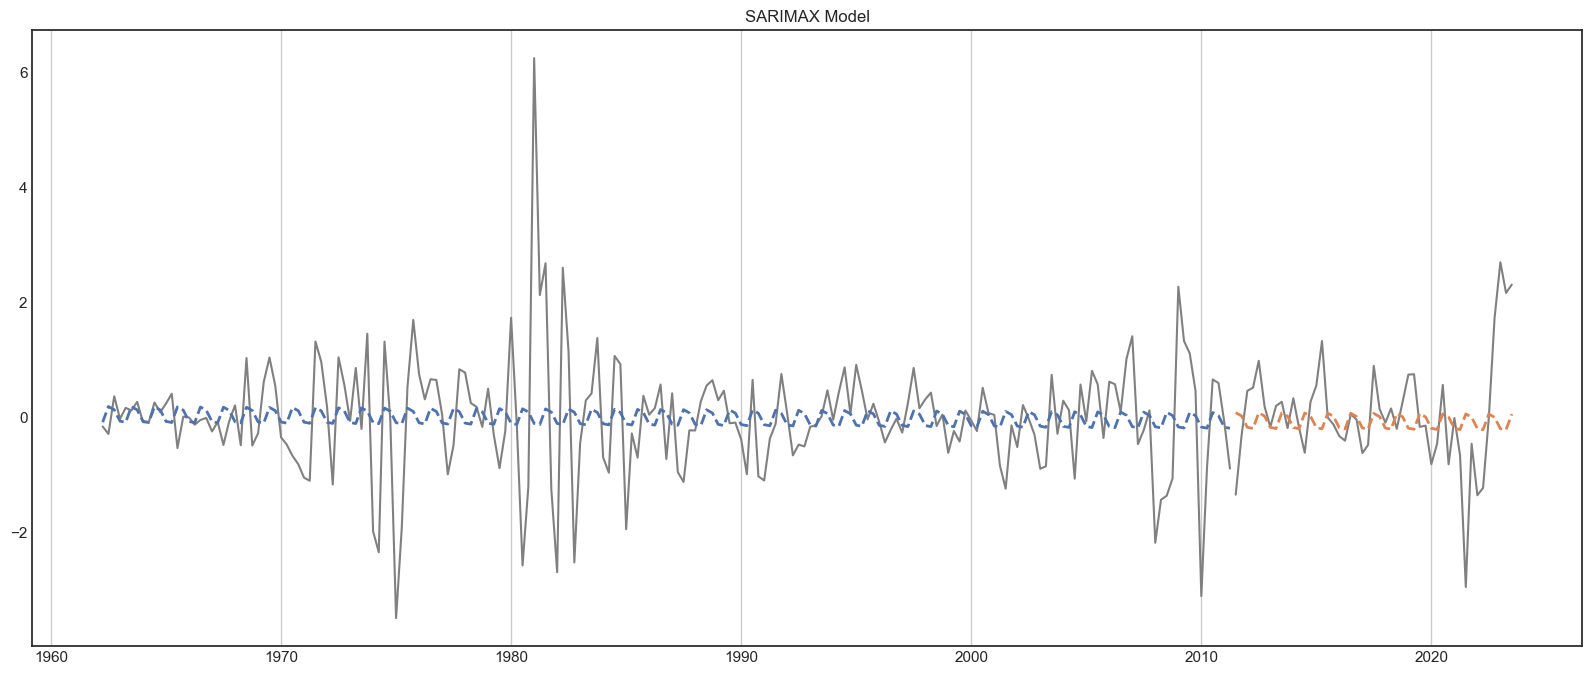

In [133]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'gray')
ax.plot(train_pred_ets.index, train_pred_ets['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_ets.index, test_pred_ets['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [134]:
model_stats_df = model_results('ets_train',y_train, train_pred_ets['mean'], fit_ets_model.aic , model_stats_df )
model_stats_df = model_results('ets_test', y_test, test_pred_ets['mean'], 0 , model_stats_df )

# Results


- A smaller MSE indicates better performance. Lower values of MSE suggest that, on average, the model's predictions have smaller deviations from the actual values, indicating higher accuracy.
- A smaller RMSE indicates better performance. Lower values of RMSE imply that, on average, the model's predictions are closer to the actual values, suggesting higher accuracy.
- A smaller MAPE indicates better performance. Lower values of MAPE imply that, on average, the model's predictions have a smaller percentage deviation from the actual values, indicating higher accuracy.
- A smaller MAE indicates better performance. Lower values of MAE indicate that, on average, the model's predictions are closer to the actual values, implying higher accuracy.
- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.

In [135]:
model_stats_df

,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,25.4002,5.0399,2.1100,4.4310,0
1,ffef_tr_test,57.2779,7.5682,41.6492,6.8936,0
2,ffef_tr2_train,1.0815,1.0400,0.2273,0.6669,0
3,ffef_tr2_test,0.3036,0.5510,3.1241,0.3807,0
4,SARIMAX_train,19.6613,4.4341,4.0859,3.1323,496.6681
5,SARIMAX_test,7.7303,2.7803,12.3821,2.4316,0
6,pmdarima_train,0.6383,0.7990,0.8963,0.4966,497.3483
7,pmdarima_test,4.6288,2.1515,10.5143,1.7668,0
8,ets_train,8.1137,2.8485,1.1434,2.3014,583.3995
9,ets_test,2.2893,1.5130,1.4664,0.9342,0
